In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ks_2samp

In [2]:
df = pd.read_csv("./data/transactions_wtih_target.csv")
df

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,client_id__CARD,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,is_fraud
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,...,1556,Mastercard,Debit (Prepaid),2022-07-01,1,2,55,2008-05-01,2008,0
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,...,561,Mastercard,Credit,2024-12-01,1,1,9100,2005-09-01,2015,0
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,...,1129,Mastercard,Debit,2020-05-01,1,1,14802,2006-01-01,2008,0
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,...,848,Visa,Debit,2020-01-01,1,1,19113,2009-07-01,2014,0
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464,...,1807,Mastercard,Debit (Prepaid),2014-03-01,1,1,89,2008-01-01,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7807581,23761861,2019-10-31 23:52:00,234,5178,40.00,Swipe Transaction,27092,Dallas,TX,75208,...,234,Visa,Debit,2021-08-01,0,2,6532,2009-10-01,2009,0
7807582,23761862,2019-10-31 23:54:00,672,5001,12.93,Chip Transaction,47508,Cosby,TN,37722,...,672,Visa,Debit,2020-01-01,1,1,8333,2003-10-01,2007,0
7807583,23761863,2019-10-31 23:54:00,1384,3723,67.01,Chip Transaction,58136,Williamson,GA,30292,...,1384,Visa,Debit,2020-02-01,1,2,24617,2004-07-01,2006,0
7807584,23761868,2019-10-31 23:56:00,1718,2379,1.11,Chip Transaction,86438,West Covina,CA,91792,...,1718,Mastercard,Debit,2020-02-01,1,1,26743,2019-03-01,2019,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7807586 entries, 0 to 7807585
Data columns (total 41 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     int64  
 1   date                   object 
 2   client_id              int64  
 3   card_id                int64  
 4   amount                 float64
 5   use_chip               object 
 6   merchant_id            int64  
 7   merchant_city          object 
 8   merchant_state         object 
 9   zip                    int64  
 10  mcc                    int64  
 11  hour                   int64  
 12  dow                    int64  
 13  amount_pos_            float64
 14  amount_log1p           float64
 15  is_refund              int64  
 16  amount_pos             float64
 17  amount_neg             float64
 18  zip_str                int64  
 19  current_age            int64  
 20  retirement_age         int64  
 21  birth_year             int64  
 22  birth_month       

### 일별 사기/비사기 건수 & 사기율 

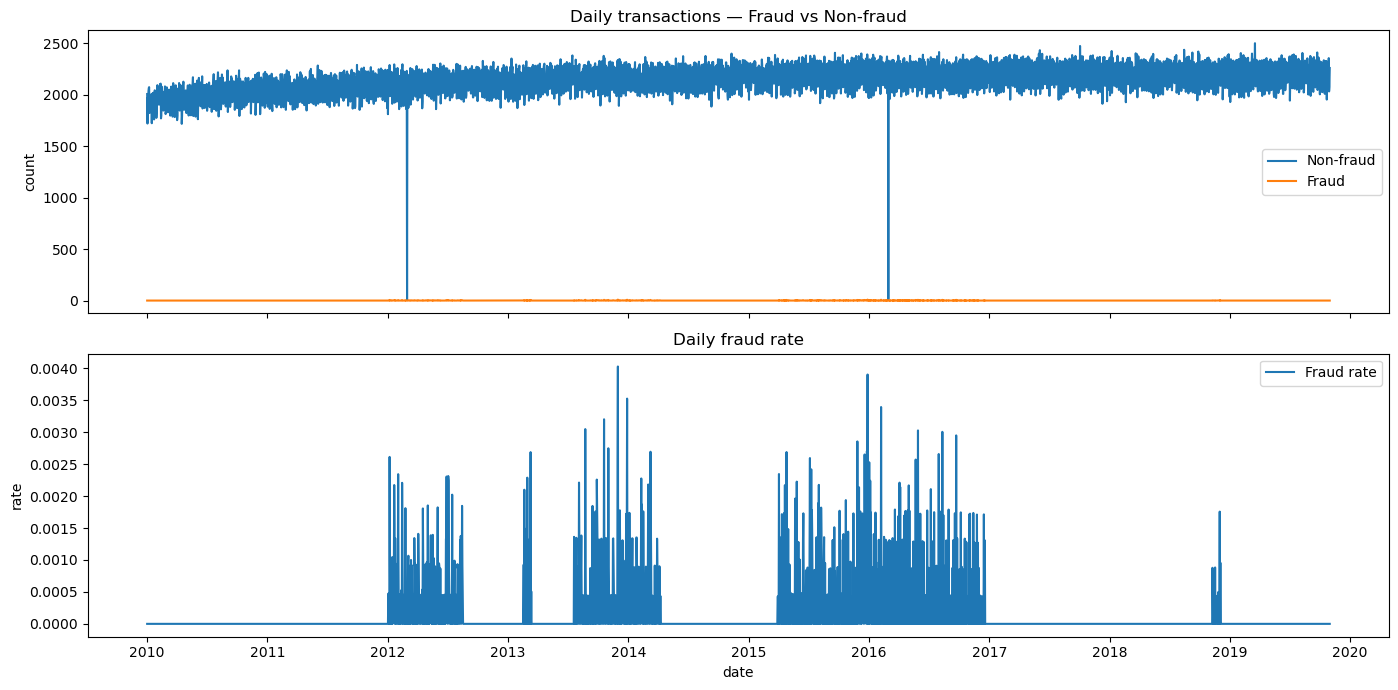

In [4]:
#  일별 사기/비사기 건수 집계
df["date"] = pd.to_datetime(df["date"])
daily = (df.assign(date=df["date"].dt.floor("D"))
           .groupby(["date","is_fraud"]).size()
           .unstack(fill_value=0)
           .rename(columns={0:"non_fraud",1:"fraud"})
           .sort_index())

# 일별 사기율
daily["fraud_rate"] = daily["fraud"] / (daily["fraud"] + daily["non_fraud"])

fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
axes[0].plot(daily.index, daily["non_fraud"], label="Non-fraud")
axes[0].plot(daily.index, daily["fraud"], label="Fraud")
axes[0].set_title("Daily transactions — Fraud vs Non-fraud")
axes[0].set_ylabel("count")
axes[0].legend()

axes[1].plot(daily.index, daily["fraud_rate"], label="Fraud rate")
axes[1].set_title("Daily fraud rate")
axes[1].set_ylabel("rate")
axes[1].set_xlabel("date")
axes[1].legend()
plt.tight_layout()
plt.show()

- 일별 거래 수
  - 파란색(비사기)이 전 기간 내내 안정적으로 높음
  - 두 번의 수직 하락은 특정 날짜에 집계가 거의 없거나 누락된 날로 보이는 데이터 갭
- 일별 사기율
  - 2012~2016년 사이에 사기율이 높음
    - 라벨 커버리지 편향: 양성 라벨이 특정 구간에만 제공되어 그때만 사기율이 보임
    - 데이터 갭: 수직 하락일은 ETL 오류/휴일/누락일 가능성(분모 작아지면 비율 변동 과장)
    - 실제 현상 
      - 채널 믹스/위험 동행성
      - EMV(칩) 도입 전후의 구조적 변화
      - 특정 업종·지역 타깃 
      - 가맹점/네트워크 운영 요인
      - 고액/즉시 현금화 품목 비중 증가
      - 보안 사고 이후의 카드 남용

라벨 커버리지 편향 / 데이터 갭 확인
- 2012-01-03 ~ 2018-12-03 데이터 누락 가능성 높음 
- 2012/2016-02-29 데이터 누락 가능성 높음 
- 데이터 필터링 여부 논의 필요 

In [5]:
daily = (df.assign(d=df["date"].dt.floor("D")).groupby("d")["is_fraud"].agg(total="size", fraud="sum", rate="mean"))

# 양성 라벨이 존재하는 기간
active = daily[daily["fraud"] > 0]
print("Fraud-active window:", active.index.min(), "→", active.index.max())

# 데이터 갭 상위 확인(총건수 급감일)
print(daily.sort_values("total").head(5))

Fraud-active window: 2012-01-03 00:00:00 → 2018-12-03 00:00:00
            total  fraud  rate
d                             
2012-02-29      4      0   0.0
2016-02-29     10      0   0.0
2010-04-16   1718      0   0.0
2010-01-02   1721      0   0.0
2010-01-15   1724      0   0.0


채널 믹스/위험 동행성
- 결제 방식별 위험도
- 결제 방식 구성비 변화가 전체 위험에 미치는 영향

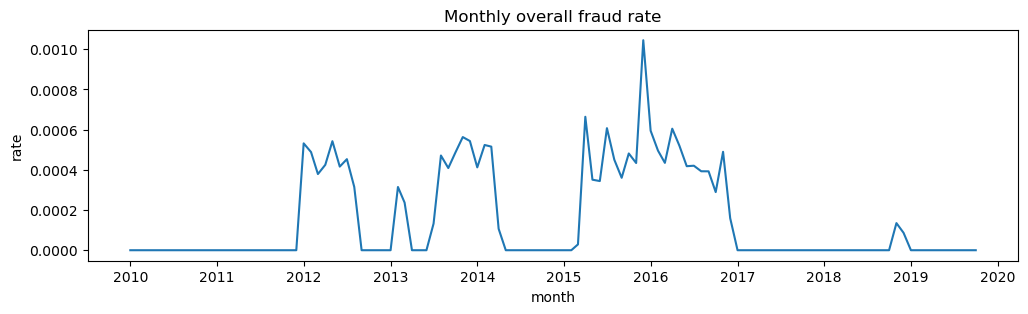

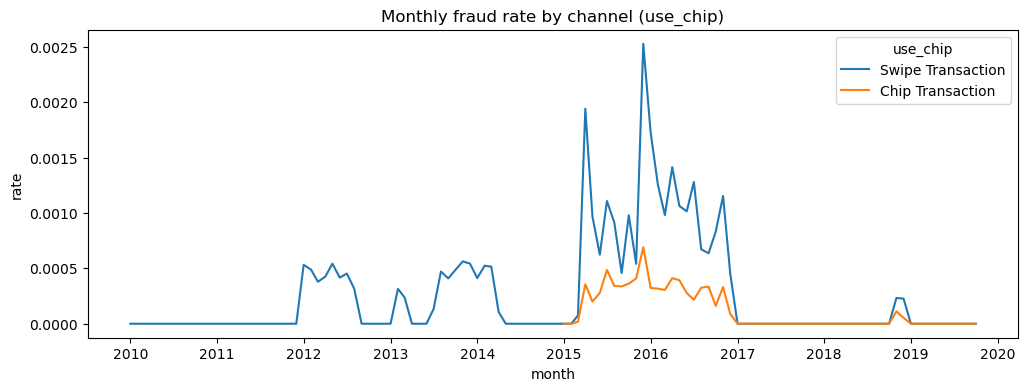

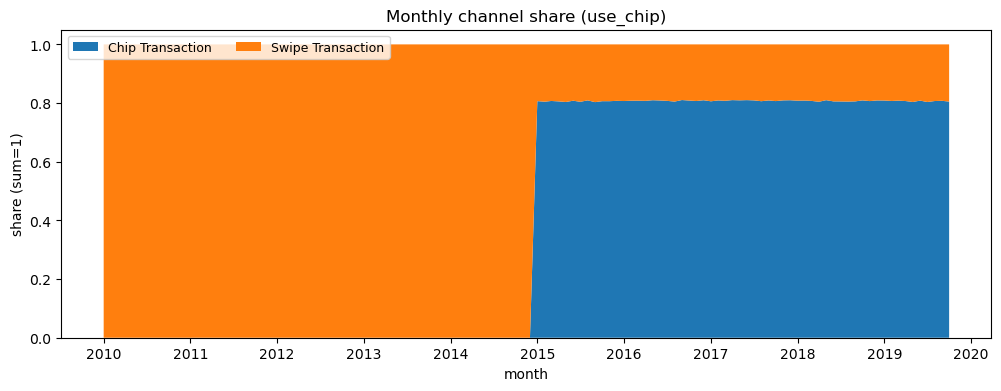

In [6]:
# 결제 방식별 월간 지표 테이블 
df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()
gm = (df.groupby(["month","use_chip"])["is_fraud"].agg(n="size", rate="mean").reset_index())
# 그 달 전체 거래 중 해당 결제 방식의 구성비
gm["share"] = gm["n"] / gm.groupby("month")["n"].transform("sum")

# 월간 전체 사기율(참고용)
monthly = (df.groupby("month")["is_fraud"].agg(n="size", fraud="sum", rate="mean").reset_index())
plt.figure(figsize=(12,3))
sns.lineplot(data=monthly, x="month", y="rate")
plt.title("Monthly overall fraud rate")
plt.ylabel("rate"); plt.xlabel("month")
plt.show()

# 결제 방식별 월간 사기율
plt.figure(figsize=(12,4))
sns.lineplot(data=gm, x="month", y="rate", hue="use_chip")
plt.title("Monthly fraud rate by channel (use_chip)")
plt.ylabel("rate"); plt.xlabel("month")
plt.show()

# 결제 방식 구성비 변화(누적 면적)
share_pv = (gm.pivot(index="month", columns="use_chip", values="share").sort_index().fillna(0))
fig, ax = plt.subplots(figsize=(12,4))
ax.stackplot(share_pv.index, share_pv.T, labels=share_pv.columns)
ax.set_title("Monthly channel share (use_chip)")
ax.set_ylabel("share (sum=1)"); ax.set_xlabel("month")
ax.legend(loc="upper left", ncol=3, fontsize=9)
plt.show()

- 칩 도입 전후 전환기(2015–2016)에 인증 실패/폴백/절차 혼선이 많아지고, 그 틈을 노린 공격이 있었을 수 있음

칩카드 스와이프 폴백 추이

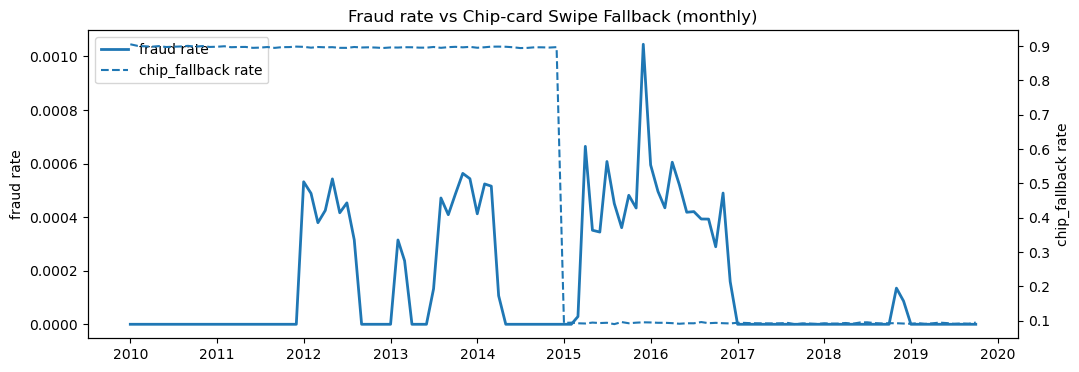

corr(fraud_rate, chip_fallback_rate) = -0.083


In [7]:
# chip_fallback: 칩이 있는 카드인데 스와이프로 처리된 거래면 1, 아니면 0
df["chip_fallback"] = ((df["has_chip"]==1) & (df["use_chip"]=="Swipe Transaction")).astype("int8")
fallback = (df.groupby("month").agg(fallback_rate=("chip_fallback","mean"), 
                                    fraud_rate =("is_fraud","mean"), n =("is_fraud","size"),
                                    fraud =("is_fraud","sum")).reset_index())

# 칩-스와이프 폴백 vs 사기율
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(fallback["month"], fallback["fraud_rate"], label="fraud rate", linewidth=2)
ax1.set_ylabel("fraud rate")

ax2 = ax1.twinx()
ax2.plot(fallback["month"], fallback["fallback_rate"], label="chip_fallback rate", linestyle="--")
ax2.set_ylabel("chip_fallback rate")
ax1.set_title("Fraud rate vs Chip-card Swipe Fallback (monthly)")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc="upper left")
plt.show()

corr = fallback[["fraud_rate","fallback_rate"]].corr().iloc[0,1]
print(f"corr(fraud_rate, chip_fallback_rate) = {corr:.3f}")

- 폴백 비율(점선): 2012~2014년에는 매우 높고(약 0.8 부근), 2015년 즈음에 급감(약 0.1 부근) 후 낮은 수준으로 유지   
  → 칩 보급·정책 전환(EMV 도입)으로 칩 사용이 늘고, 폴백은 크게 줄었다는 신호
- 사기율(실선): 2015–2016년에 뚜렷한 스파이크 이후 급락   
  → 전환기(칩 도입 초반)에 사기 시도가 집중되었거나, 스와이프의 자체 위험도가 그 시기에 상승했을 가능성

### 사기/비사기 금액 분포

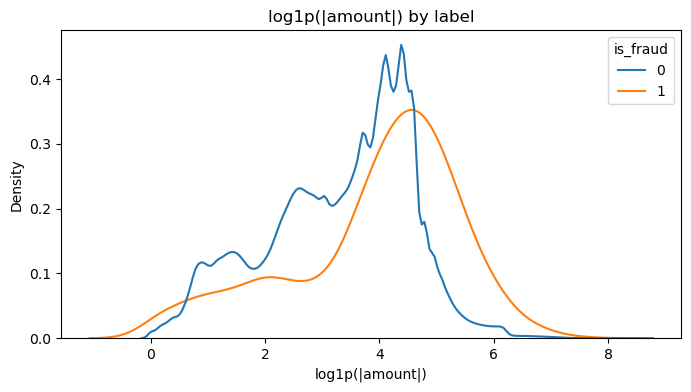

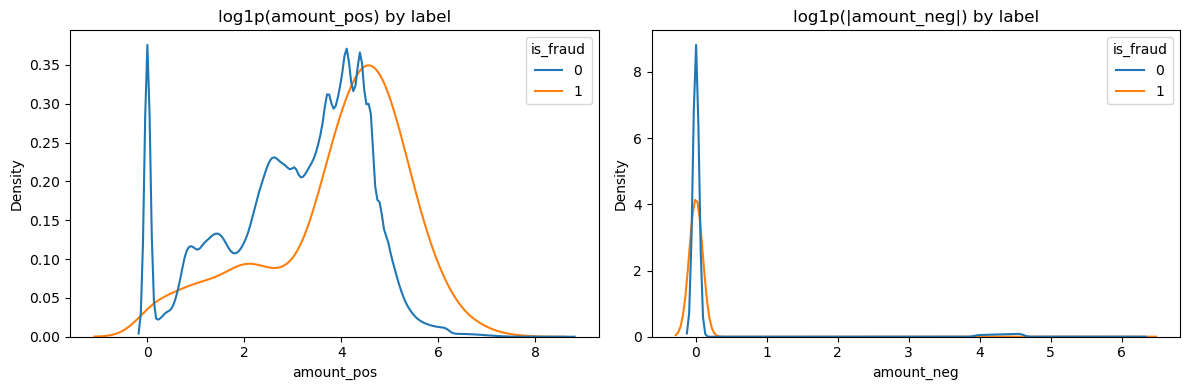

In [8]:
# 금액 분포(라벨별)
plt.figure(figsize=(8,4))
sns.kdeplot(data=df, x=np.log1p(np.abs(df["amount"])),
            hue="is_fraud", common_norm=False)
plt.title("log1p(|amount|) by label")
plt.xlabel("log1p(|amount|)")
plt.show()

# 양/음수 금액 분해(있을 때)
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.kdeplot(x=np.log1p(df["amount_pos"]), hue=df["is_fraud"],
            common_norm=False, ax=ax[0])
ax[0].set_title("log1p(amount_pos) by label")
sns.kdeplot(x=np.log1p(-df["amount_neg"].clip(upper=0)), hue=df["is_fraud"],
            common_norm=False, ax=ax[1])
ax[1].set_title("log1p(|amount_neg|) by label")
plt.tight_layout(); plt.show()

- log1p(|amount|)
  - 주황(사기=1)이 파랑(비사기=0)보다 오른쪽으로 살짝 이동하고 꼬리가 더 두꺼움   
    → 사기 거래가 전반적으로 ‘금액이 더 큼’을 시사
  - 파랑선이 다봉(multi-modal)인건 정상 거래의 업종/가격대 혼합 영향
- 양수 금액: log1p(amount_pos)
  - log1p(|amount|)와 유사 
- 음수 금액: log1p(|amount_neg|)
  - 대부분 0 부근 작은 금액, 두 라벨 분포 큰 차이 없음 → 환불/취소 자체는 강한 분리 신호 아님

### 시간대별/요일별 패턴

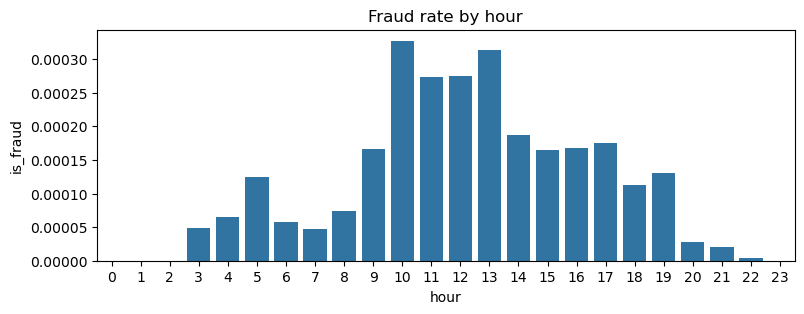

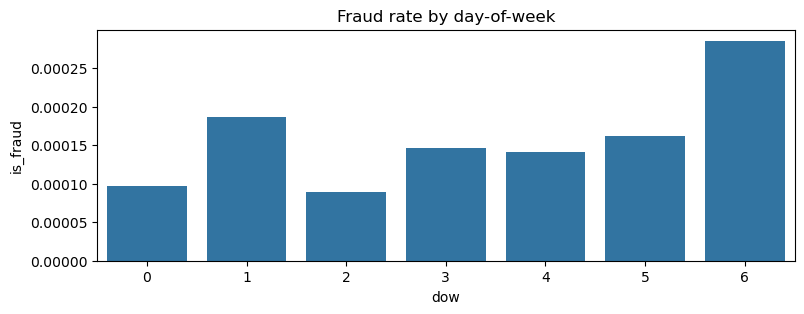

In [9]:
plt.figure(figsize=(9,3))
sns.barplot(x="hour", y="is_fraud", data=df, estimator=np.mean, errorbar=None)
plt.title("Fraud rate by hour")
plt.show()

plt.figure(figsize=(9,3))
sns.barplot(x="dow", y="is_fraud", data=df, estimator=np.mean, errorbar=None)
plt.title("Fraud rate by day-of-week")
plt.show()

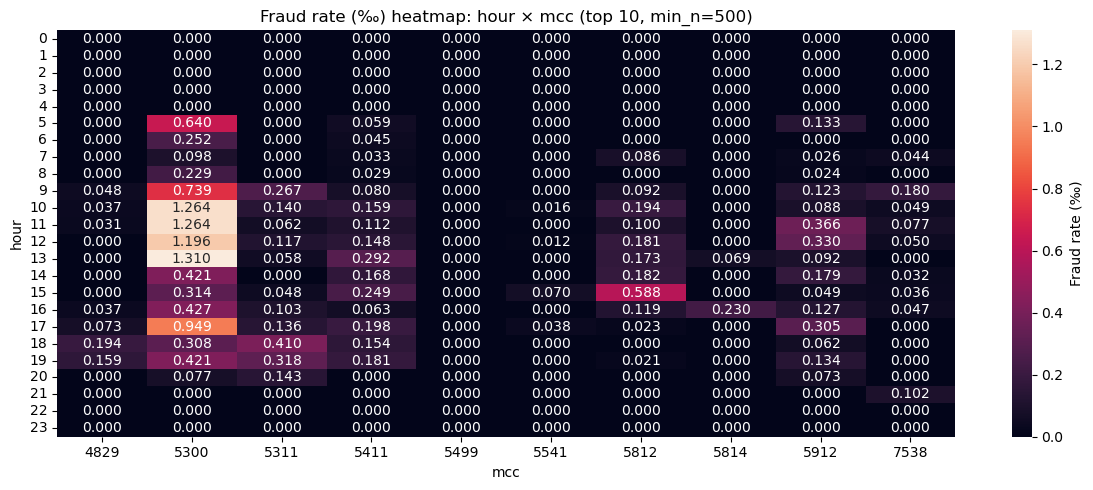

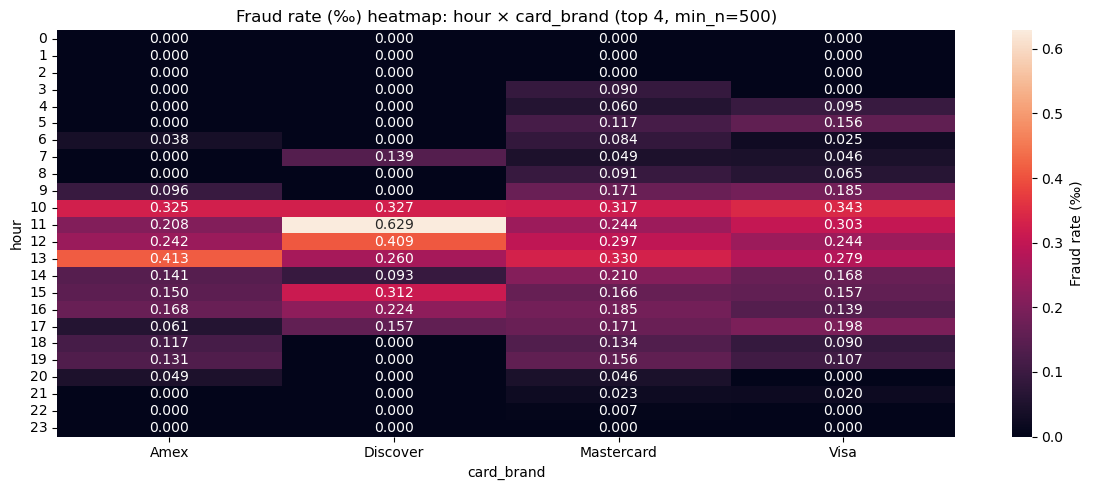

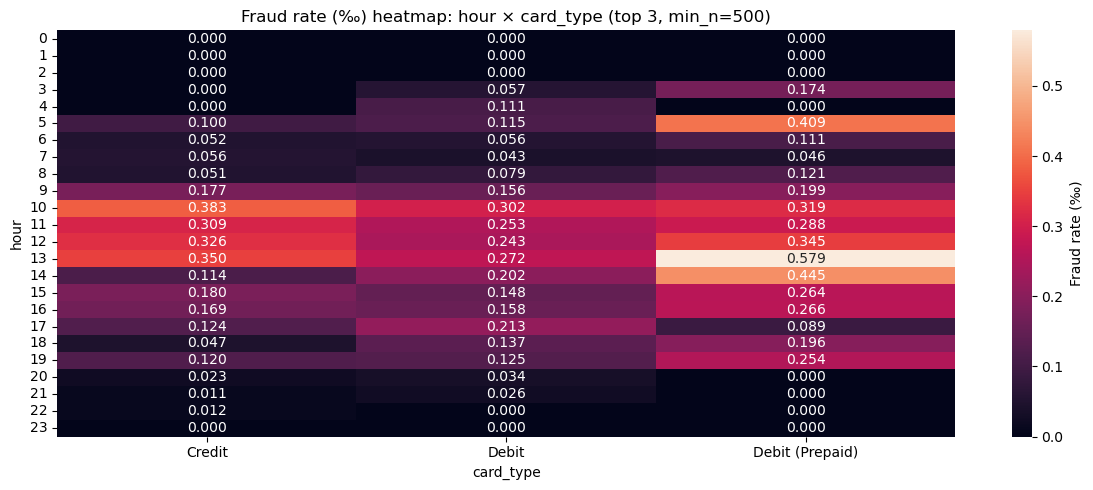

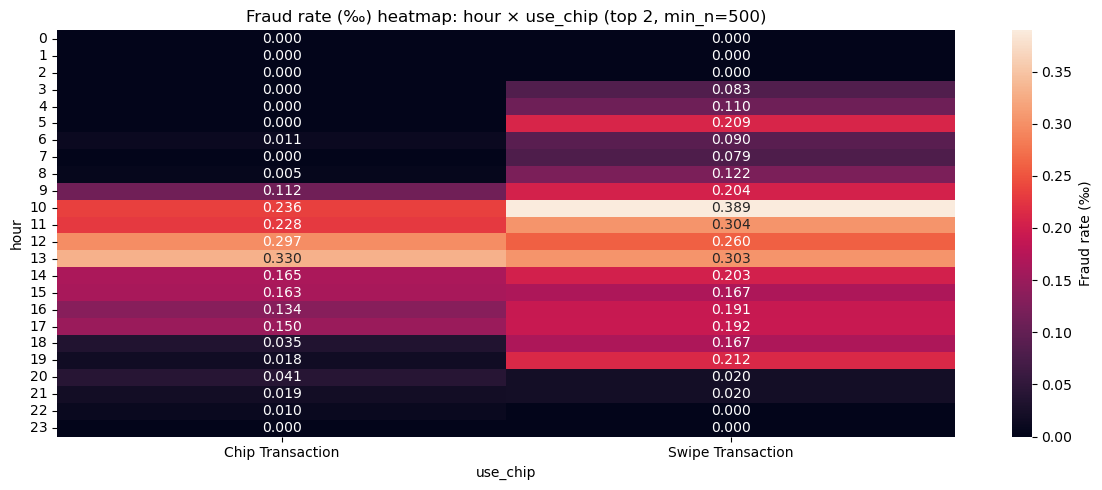

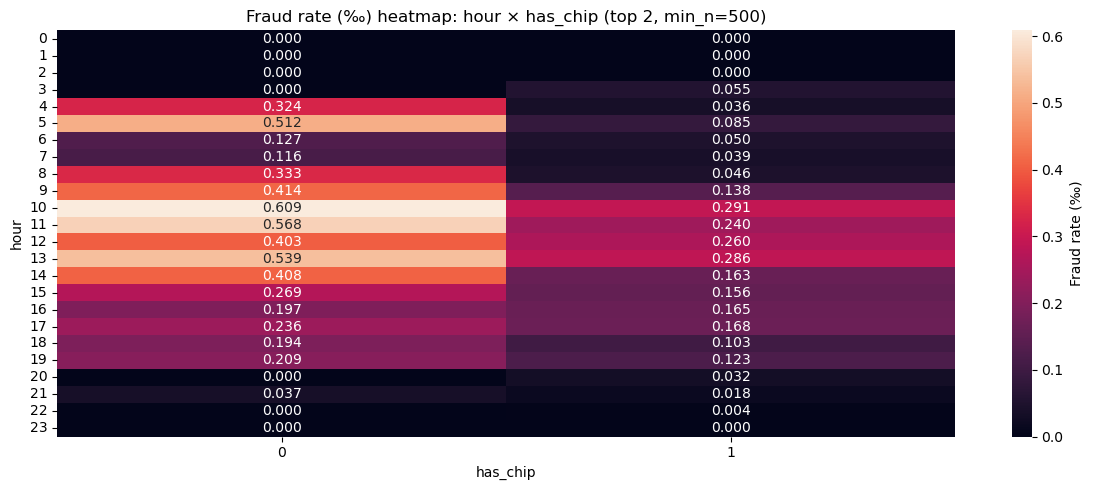

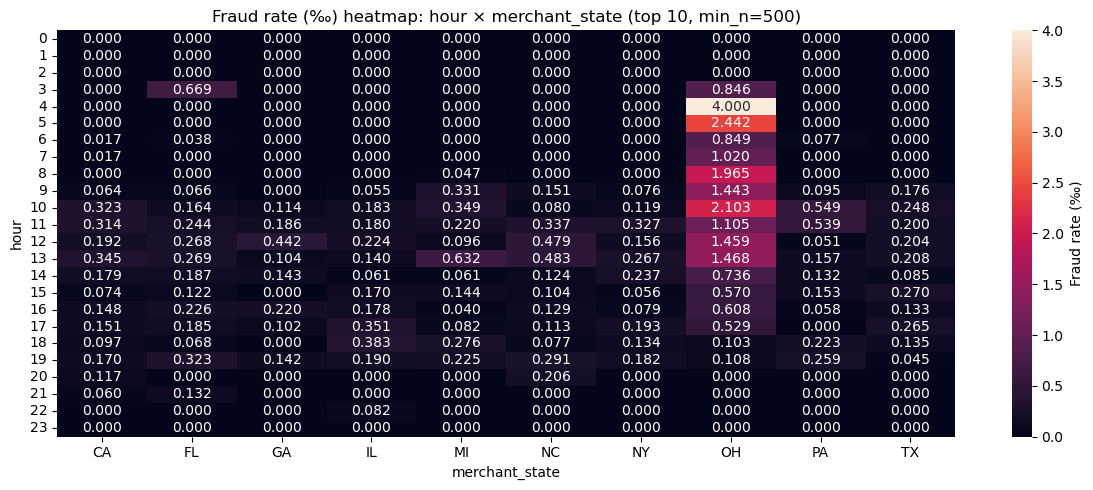

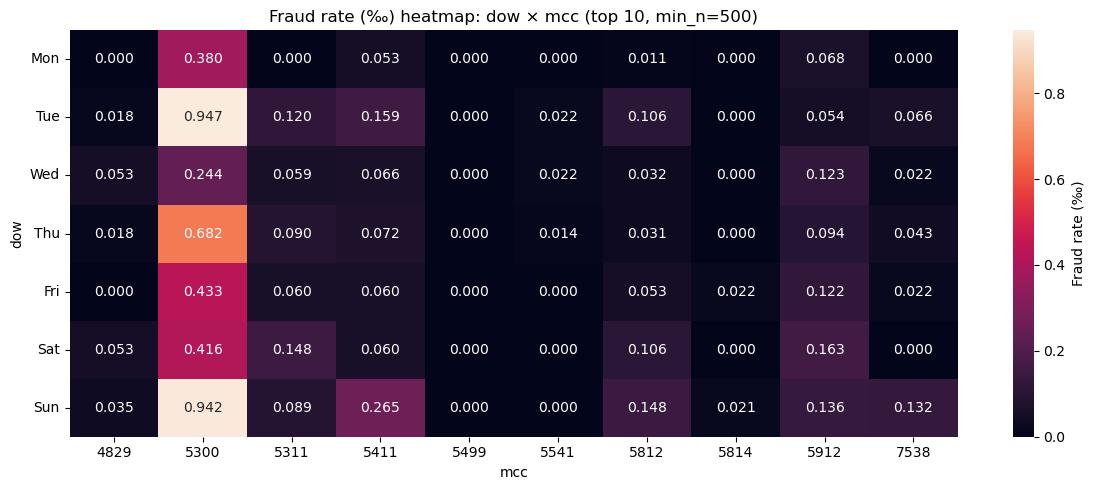

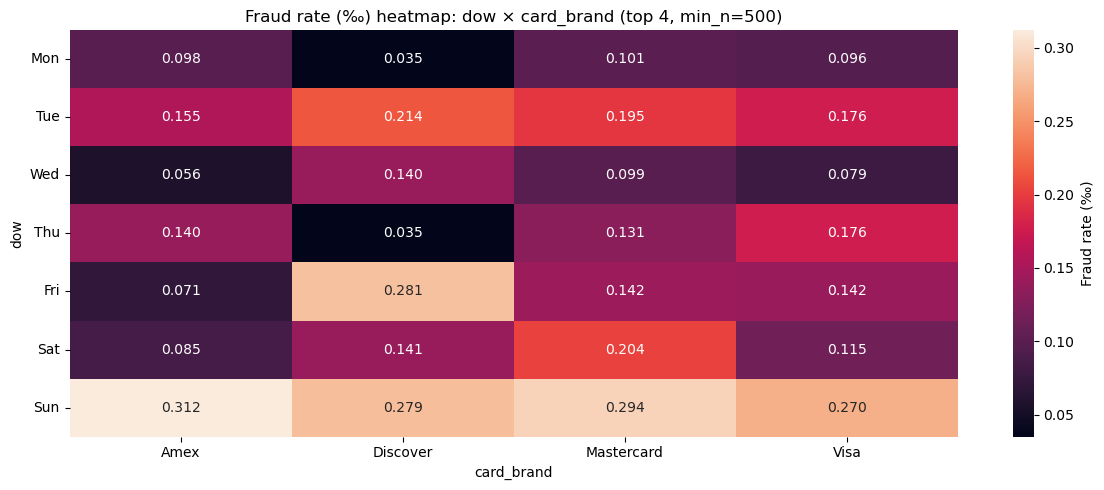

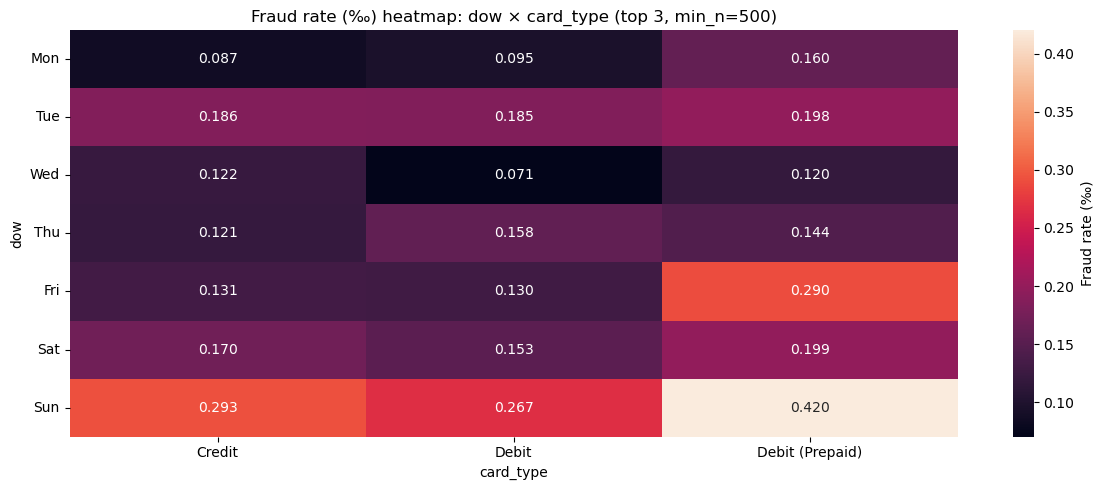

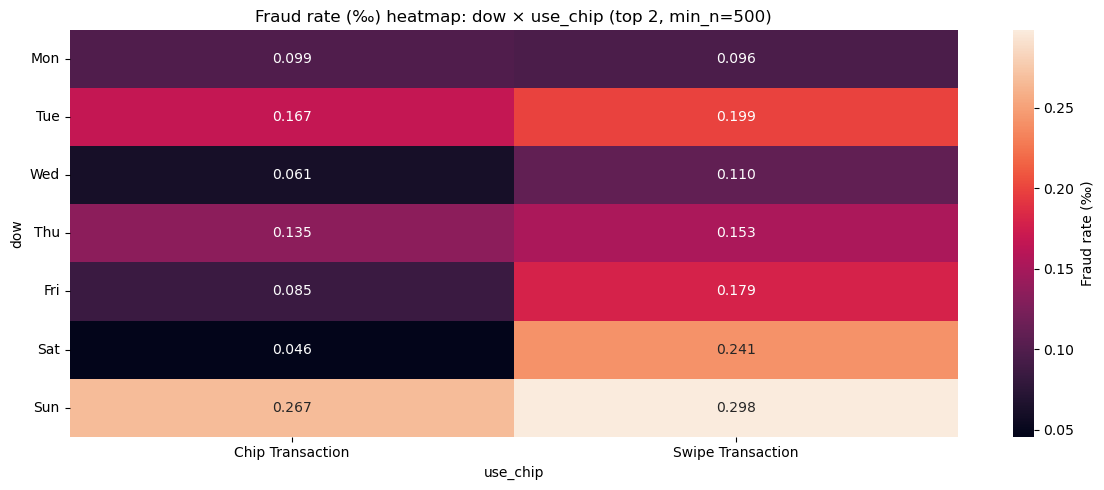

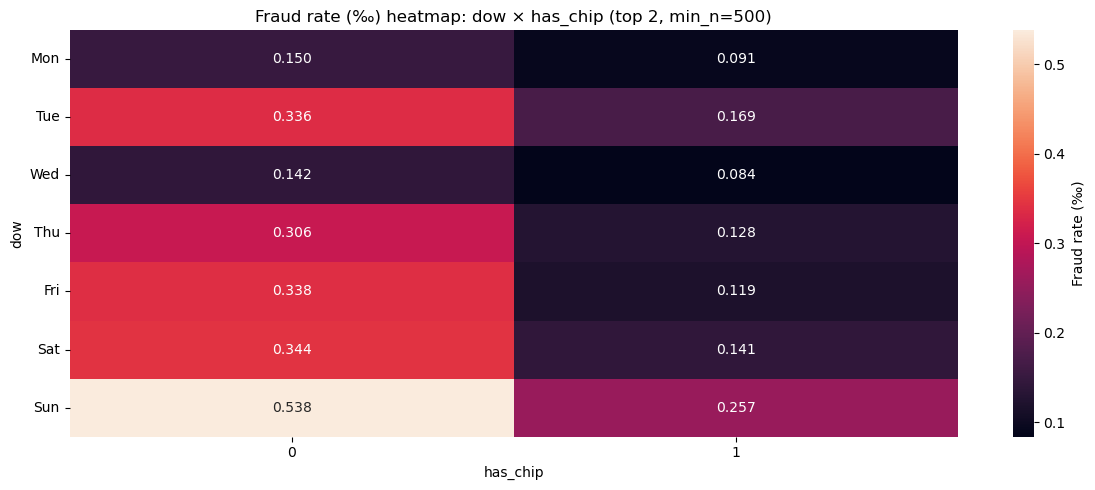

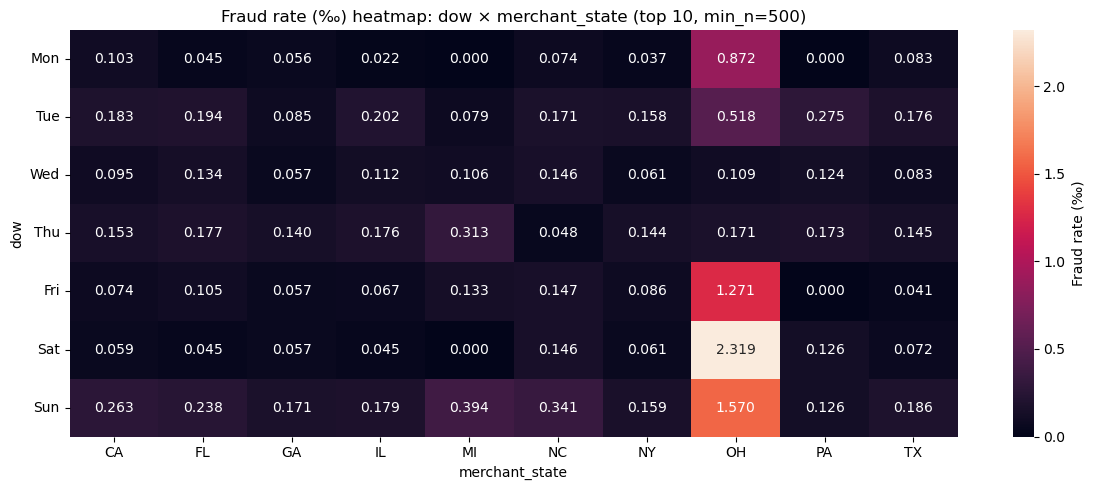

In [10]:
SCALE = 1000   # per-mille(‰)
UNIT = "‰"
FMT = ".3f"

cat_cols = ["mcc","card_brand","card_type","use_chip","has_chip","merchant_state","zip3"]

def heatmap_time_by_cat(df, time_col, cat_col, top_k=10, min_n=500):
    sub = df[[time_col, cat_col, "is_fraud"]].dropna().copy()
    sub["is_fraud"] = pd.to_numeric(sub["is_fraud"], errors="coerce")
    if cat_col in ("mcc", "zip3"):
        sub[cat_col] = sub[cat_col].astype("string")  

    # 상위 K 레벨만 / 피벗
    top_levels = sub[cat_col].value_counts().head(top_k).index
    sub = sub[sub[cat_col].isin(top_levels)]
    pv_rate = sub.pivot_table(index=time_col, columns=cat_col,values="is_fraud", aggfunc="mean")
    pv_cnt  = sub.pivot_table(index=time_col, columns=cat_col,values="is_fraud", aggfunc="size").fillna(0)

    # 시간 축 정렬
    if time_col == "hour":
        pv_rate = pv_rate.reindex(range(24))
        pv_cnt  = pv_cnt.reindex(range(24)).fillna(0)
    elif time_col == "dow":
        pv_rate = pv_rate.reindex(range(7))
        pv_cnt  = pv_cnt.reindex(range(7)).fillna(0)

    # 표본 수가 적은 셀은 가리기
    pv_show = pv_rate.copy()
    pv_show[pv_cnt < min_n] = np.nan
    vals = (pv_show * SCALE).astype(float)

    plt.figure(figsize=(12, 5))
    ax = sns.heatmap(vals, annot=True, fmt=FMT, cmap="rocket",
                     cbar_kws={"label": f"Fraud rate ({UNIT})"})
    if time_col == "dow":
        ax.set_yticklabels(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
    ax.set_title(f"Fraud rate ({UNIT}) heatmap: {time_col} × {cat_col} "
                 f"(top {len(top_levels)}, min_n={min_n})")
    ax.set_ylabel(time_col); ax.set_xlabel(cat_col)
    plt.tight_layout(); plt.show()

for tcol in [c for c in ["hour","dow"] if c in df.columns]:
    for ccol in cat_cols:
        if ccol in df.columns:
            heatmap_time_by_cat(df, time_col=tcol, cat_col=ccol, top_k=10, min_n=500)

- 시간대: 대부분 10–15시에 사기율이 최댓값, 새벽/야간은 거의 0
- 요일: 일요일이 전 범주에서 가장 높고 화요일이 그 다음
- Swipe Transaction이 Chip보다 지속적으로 높음(시간·요일 모두)
- has_chip=0(칩 비탑재 카드)가 has_chip=1보다 전반적으로 높음
- MCC(업종)
  - 5300 Wholesale Clubs(창고형 할인점): 대형 장바구니/비정기 고액. 주말·정오 시간대 스파이크가 흔함
  - 5812 Restaurants, 5814 Fast Food: 소액 다빈도, 점심/저녁 피크. 특정 시간대 집중 패턴이 뚜렷
  - 5311 Department Stores: 고가 품목·대면 결제. 스와이프 비중이 높던 시기에 리스크↑ 가능
  - 5411 Groceries, 5499 Misc Food Stores: 생필품/식료품. 정상 거래가 많아 사기율은 낮지만 분모가 커 손실 기여도는 무시 못 함.
- merchant_state
  - OH, MI 등 일부 주에서 정오~오후 고점이 크고 주말 상승이 큼
- 카드 브랜드/유형
  - 브랜드별로는 전반 패턴(정오 피크, 일요일 고점)이 유사하며 레벨 차만 존재
  - 카드 유형은 Debit(특히 Prepaid) 쪽이 오후(13–16시) 상승이 뚜렷 → 선불/직불 특성(잔액 확인/한도 관리 허점, 즉시 현금화 품목)과 맞물릴 수 있음

### 범주별 사기율 테이블(Top-N) : 단일 범주별 전체 기간의 사기건수/사기율

In [11]:
cat_cols = ["mcc","merchant_state","card_brand","card_type","use_chip","has_chip"]
min_n = 100   # 표본 하한
top = 10    

def rate_tables(df, by, min_n=100, top=10):
    g = (df.groupby(by)["is_fraud"]
           .agg(n="size", fraud="sum", rate="mean")
           .reset_index())
    g = g[g["n"] >= min_n]

    top_rate = (g.sort_values("rate", ascending=False).head(top).reset_index(drop=True))
    top_rate["rate_pct"] = (top_rate["rate"]*100).round(3)

    top_cnt  = (g.sort_values("fraud", ascending=False).head(top).reset_index(drop=True))
    top_cnt["rate_pct"] = (top_cnt["rate"]*100).round(3)

    return top_rate, top_cnt

for col in cat_cols:
    tr, tc = rate_tables(df, col, min_n=min_n, top=top)
    pair = pd.concat({"Top RATE": tr, "Top COUNT": tc}, axis=1)
    print(f"\n=== {col}: Top {top} by rate vs Top {top} by count (min_n={min_n}) ===")
    display(pair)


=== mcc: Top 10 by rate vs Top 10 by count (min_n=100) ===


Top RATE                                Top COUNT                           \
       mcc     n fraud      rate rate_pct       mcc        n fraud      rate   
0     5733   142    14  0.098592    9.859      5300   402266   232  0.000577   
1     5722   226     7  0.030973    3.097      5411  1057606   111  0.000105   
2     7549   732     7  0.009563    0.956      5310   164497   107  0.000650   
3     5094  3289    29  0.008817    0.882      5651    42494    61  0.001435   
4     7996  3816    29  0.007600    0.760      5813   163919    60  0.000366   
5     7531   757     5  0.006605    0.661      5921    85219    56  0.000657   
6     5712  2184    14  0.006410    0.641      5912   515311    56  0.000109   
7     5193  2689    16  0.005950    0.595      5812   659934    46  0.000070   
8     5932  3856    22  0.005705    0.571      4121   137791    35  0.000254   
9     5941   741     3  0.004049    0.405      7995    21348    34  0.001593   

            
  rate_pct  
0    0.058  
1    0.010  
2    0.065  
3    0.144  
4    0.037  
5    0.066  
6    0.011  
7    0.007  
8    0.025  
9    0.159


=== merchant_state: Top 10 by rate vs Top 10 by count (min_n=100) ===


Top RATE                                       Top COUNT          \
  merchant_state       n fraud      rate rate_pct merchant_state       n   
0             OH  324098   316  0.000975    0.098             OH  324098   
1             SD   20875     8  0.000383    0.038             CA  956356   
2             IA  107765    32  0.000297    0.030             TX  677139   
3             MO  131274    32  0.000244    0.024             FL  469600   
4             NJ  216075    42  0.000194    0.019             NY  574521   
5             WY    5874     1  0.000170    0.017             NC  286937   
6             MS   88984    15  0.000169    0.017             NJ  216075   
7             VA  154841    26  0.000168    0.017             MI  266745   
8             UT   25322     4  0.000158    0.016             IL  313592   
9             HI   51062     8  0.000157    0.016             PA  280037   

                            
  fraud      rate rate_pct  
0   316  0.000975    0.098  
1   127  0.000133    0.013  
2    76  0.000112    0.011  
3    63  0.000134    0.013  
4    58  0.000101    0.010  
5    44  0.000153    0.015  
6    42  0.000194    0.019  
7    39  0.000146    0.015  
8    36  0.000115    0.011  
9    33  0.000118    0.012


=== card_brand: Top 10 by rate vs Top 10 by count (min_n=100) ===


Top RATE                                     Top COUNT                 \
   card_brand        n fraud      rate rate_pct  card_brand        n fraud   
0  Mastercard  4194185   698  0.000166    0.017  Mastercard  4194185   698   
1    Discover   199295    32  0.000161    0.016        Visa  2917767   439   
2        Visa  2917767   439  0.000150    0.015        Amex   496339    65   
3        Amex   496339    65  0.000131    0.013    Discover   199295    32   

                      
       rate rate_pct  
0  0.000166    0.017  
1  0.000150    0.015  
2  0.000131    0.013  
3  0.000161    0.016


=== card_type: Top 10 by rate vs Top 10 by count (min_n=100) ===


Top RATE                                          Top COUNT  \
         card_type        n fraud      rate rate_pct        card_type   
0  Debit (Prepaid)   529606   116  0.000219    0.022            Debit   
1           Credit  2418988   383  0.000158    0.016           Credit   
2            Debit  4858992   735  0.000151    0.015  Debit (Prepaid)   

                                     
         n fraud      rate rate_pct  
0  4858992   735  0.000151    0.015  
1  2418988   383  0.000158    0.016  
2   529606   116  0.000219    0.022


=== use_chip: Top 10 by rate vs Top 10 by count (min_n=100) ===


Top RATE                                            Top COUNT  \
            use_chip        n fraud      rate rate_pct           use_chip   
0  Swipe Transaction  4635735   844  0.000182    0.018  Swipe Transaction   
1   Chip Transaction  3171851   390  0.000123    0.012   Chip Transaction   

                                     
         n fraud      rate rate_pct  
0  4635735   844  0.000182    0.018  
1  3171851   390  0.000123    0.012


=== has_chip: Top 10 by rate vs Top 10 by count (min_n=100) ===


Top RATE                                   Top COUNT                 \
  has_chip        n fraud      rate rate_pct  has_chip        n fraud   
0        0   792449   244  0.000308    0.031         1  7015137   990   
1        1  7015137   990  0.000141    0.014         0   792449   244   

                      
       rate rate_pct  
0  0.000141    0.014  
1  0.000308    0.031

- 결제방식
  - Swipe > Chip : 사기율이 약 1.5배(0.000182 / 0.000123)   
    → 시간/요일 분석과도 일치(정오~오후, 주말) : 스와이프 구간 모니터링 강화 필요
  - has_chip=0 > 1 : ~2.2배(0.000308 / 0.000141)   
    → 칩 미탑재/구형 카드가 더 위험. 폴백(has_chip=1 & Swipe)도 별도 지표로 보강 
- 카드유형/브랜드
  - Prepaid Debit 사기율이 가장 높고(≈0.022%), Debit 전체가 건수 기여도가 큼   
    → 선불/직불은 한도·속성상 오남용 리스크↑. 금액·빈도 규칙 강화 후보
  - 브랜드별 차이는 작은 편(Mastercard > Discover > Visa > Amex 순으로 아주 근소)   
    → 단독 규칙보단 MCC/방식/시간과의 교차 피처가 더 유효
- 지역(merchant_state)
  - OH가 비율∙건수 모두 1위(rate≈0.0975%)   
    → 지역/가맹점 구성·정책 차이 가능성. OH 우선 심층 점검(가맹점 상위, 방식 믹스, 시간대)
- 업종(MCC)
  - 건수 : 창고형 할인점, 식료품/슈퍼, 할인점, 의류, 주점, 주류 소매, 약국, 레스토랑, 택시/리무진, 베팅/카지노
  - 비율 : 악기점, 가전, 견인/구난, 귀금속, 놀이공원/축제, 차량 판금/수리, 가구/가전 비품, 골동품
    - Swipe × (5300/5411/5812/5813)에 대한 소액·다빈도 한도/속도 제한
    - Swipe 또는 chip_fallback × (5094/5712/5932/5722/7531)에 고액 추가 인증
    - 일요일·정오~오후 × 위 MCC 조합 가중 모니터링

### 기타 위험도
#### 가맹점/업종 타깃
- 소수 가맹점에 사기 사건이 집중되어 있을 수 있음

count    65826.000000
mean         0.018746
std          0.277334
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         34.000000
Name: fraud, dtype: float64

Top merchants by fraud count (fraud >= 10)


,merchant_id,n,fraud,rate
31029,47155,34,34,1.000000
382,569,694,28,0.040346
59049,90002,19,19,1.000000
19386,29437,821,14,0.017052
36339,55372,14,14,1.000000
41072,62681,15,13,0.866667
788,1187,13,13,1.000000
54572,83214,112,10,0.089286
17862,27092,393686,10,0.000025
18487,28049,10,10,1.000000


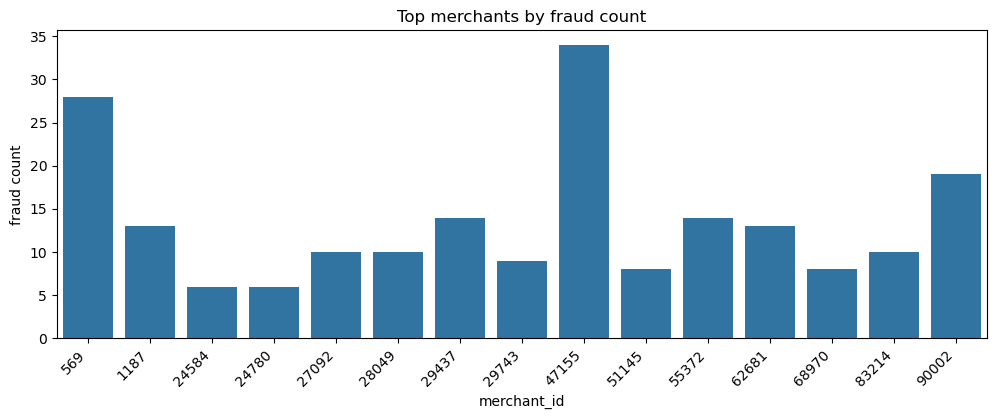

In [12]:
hot_merchants = (df.groupby("merchant_id")["is_fraud"].agg(n="size", fraud="sum", rate="mean")
                 .reset_index().sort_values("fraud", ascending=False))

print(hot_merchants["fraud"].describe())
print("\nTop merchants by fraud count (fraud >= 10)")
display(hot_merchants.head(10))

plt.figure(figsize=(12,4))
sns.barplot(data=hot_merchants.head(15), x="merchant_id", y="fraud")
plt.title("Top merchants by fraud count")
plt.ylabel("fraud count")
plt.xlabel("merchant_id")
plt.xticks(rotation=45, ha="right")
plt.show()

#### 수치형 단변량 KS 통계

In [13]:
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c not in ["is_fraud"]]
ks_rows = []
fraud = df["is_fraud"] == 1
for c in num_cols:
    a = df.loc[~fraud, c].dropna()
    b = df.loc[ fraud, c].dropna()
    if len(a)>100 and len(b)>100:
        ks = ks_2samp(a.sample(min(200_000, len(a)), random_state=42),
                      b.sample(min(200_000, len(b)), random_state=42)).statistic
        ks_rows.append((c, ks))
ks_df = pd.DataFrame(ks_rows, columns=["feature","ks"]).sort_values("ks", ascending=False).head(20)
print("\n=== Top numeric features by KS ===")
display(ks_df)


=== Top numeric features by KS ===


,feature,ks
12,amount_pos,0.289937
3,amount,0.289937
10,amount_log1p,0.289937
9,amount_pos_,0.289937
0,id,0.286944
6,mcc,0.168505
7,hour,0.159409
8,dow,0.117151
14,zip_str,0.116709
5,zip,0.116709


KS(Kolmogorov–Smirnov) 통계량 : 각 피처에서 사기(1) vs 비사기(0)의 누적분포(CDF) 차이의 최댓값
- amount / amount_pos (~0.29): 가장 강함. 금액이 커질수록 사기일 확률↑ (이미 로그/상한 처리하면 더 안정)
- id (~0.287): 매우 높지만 주의. 거래 ID가 시간과 단조증가한다면, 이 데이터의 라벨이 존재하는 기간(2012~2016 중심)과 결이 같아 시간정보를 우회적으로 학습했을 가능성이 큼 → 유의미 신호가 아니라 데이터 구조 신호일 수 있음. 모델 입력에서 제외
- mcc (~0.169): 업종은 중간 정도의 분리력. 숫자로 KS를 계산했더라도 범주형으로 처리(OOF 타깃 인코딩/그룹핑)해야 의미가 맞음
- hour (0.159), dow (0.117): 시간대/요일 효과가 존재
- zip (0.117): 우편번호 숫자 그 자체는 순서 의미 없음 → zip3 같은 범주/지역 묶음으로 쓰고, 필요하면 위험도 피처(OOF)
- has_chip (0.096): 칩 미탑재 카드가 더 위험
- merchant_id (0.091): 가맹점 레벨 위험도가 존재. 그대로 쓰면 고카디널리티 과적합 위험 → OOF 타깃 인코딩/리스크 스코어로 사용
- 고객 속성(total_debt, income, credit_limit/score 등 0.05~0.09): 거래 즉시 탐지에서는 거래 컨텍스트(금액/시간/방식/업종)보다 신호가 약함. 보조 피처로 유지
- is_refund/amount_neg (~0.049): 환불/음수는 약한 음의 신호(주로 정상 환불)

### 지도 시각화

In [ ]:
# import folium
# from folium.plugins import HeatMap, HeatMapWithTime, MarkerCluster

Fraud 밀도 히트맵 
- 사기 거래에 더 큰 가중치(1.0), 정상 거래는 소량 가중치(0.1)
- 그 지역에서의 거래 밀집도 × 사기 비중

In [ ]:
# center_lat = float(df["latitude"].median())
# center_lon = float(df["longitude"].median())

In [ ]:
# weights = np.where(df["is_fraud"].astype(int) == 1, 1.0, 0.1)
# heat_data = np.column_stack([df["latitude"].astype(float), df["longitude"].astype(float), weights]).tolist()

# m1 = folium.Map(location=(center_lat, center_lon), zoom_start=4, tiles="CartoDB positron")
# HeatMap(heat_data, radius=12, blur=15, max_zoom=8).add_to(m1)
# m1

시간대별 타임랩스 히트맵 (0~23시)
- 특정 시간대에 집중되는 사기 핫스팟 탐지

In [ ]:
# m3 = folium.Map(location=(center_lat, center_lon), zoom_start=4, tiles="CartoDB positron")
# frames, labels = [], []
# w = np.where(df["is_fraud"].astype(int) == 1, 1.0, 0.1)
# df["_w"] = w
# for h in range(24):
#     part = df[df["hour"] == h]
#     frames.append([] if len(part)==0 else part[["latitude","longitude","_w"]].astype(float).values.tolist())
#     labels.append(f"{h:02d}:00")
# HeatMapWithTime(frames, index=labels, radius=12, auto_play=True, max_opacity=0.8).add_to(m3)
# m3